In [1]:
!rm -rf /kaggle/working/*


=== Federated Round 1 ===
Client 1 | Loss: 0.5611 | Acc: 0.7787
Client 2 | Loss: 0.5641 | Acc: 0.7758
Client 3 | Loss: 0.5646 | Acc: 0.7764
Client 4 | Loss: 0.5595 | Acc: 0.7798
Client 5 | Loss: 0.5681 | Acc: 0.7746

=== Federated Round 2 ===
Client 1 | Loss: 0.3058 | Acc: 0.8770
Client 2 | Loss: 0.2999 | Acc: 0.8801
Client 3 | Loss: 0.2999 | Acc: 0.8807
Client 4 | Loss: 0.2929 | Acc: 0.8811
Client 5 | Loss: 0.3004 | Acc: 0.8791

=== Federated Round 3 ===
Client 1 | Loss: 0.2668 | Acc: 0.8922
Client 2 | Loss: 0.2687 | Acc: 0.8916
Client 3 | Loss: 0.2672 | Acc: 0.8938
Client 4 | Loss: 0.2629 | Acc: 0.8948
Client 5 | Loss: 0.2672 | Acc: 0.8918

=== Federated Round 4 ===
Client 1 | Loss: 0.2559 | Acc: 0.8957
Client 2 | Loss: 0.2551 | Acc: 0.8973
Client 3 | Loss: 0.2567 | Acc: 0.8972
Client 4 | Loss: 0.2518 | Acc: 0.8979
Client 5 | Loss: 0.2535 | Acc: 0.8967

=== Federated Round 5 ===
Client 1 | Loss: 0.2456 | Acc: 0.8993
Client 2 | Loss: 0.2464 | Acc: 0.8993
Client 3 | Loss: 0.2457 | Acc

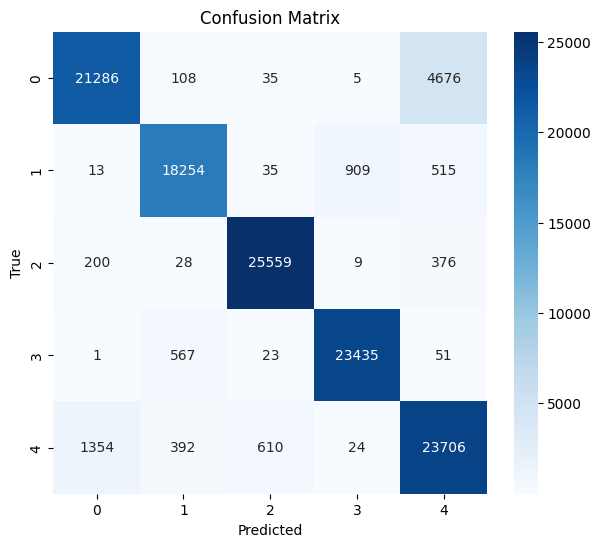

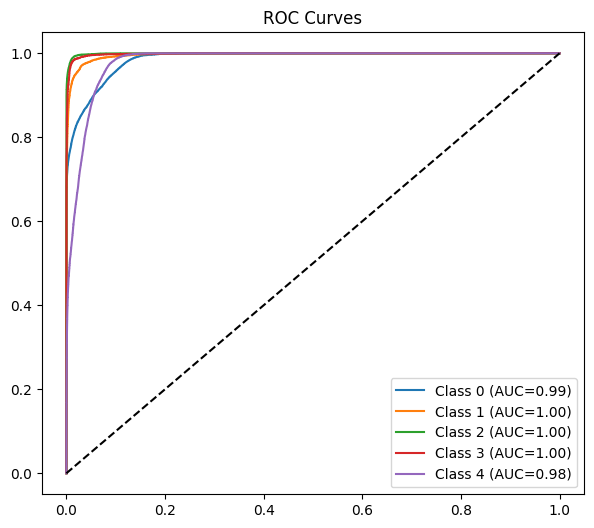


All results saved to: /kaggle/working/federated_results


In [2]:
# ============================================================
# Federated GCN for UAV Intrusion Detection
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc
)
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/federated_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 20
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
K = 5
HIDDEN_DIM = 64

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

# ---------------------------
# GRAPH CONSTRUCTION (SPARSE)
# ---------------------------
adj = kneighbors_graph(X_np, K, mode="connectivity", include_self=True)
adj = sp.coo_matrix(adj)

edge_pairs = np.vstack([adj.row, adj.col])
edge_labels = y_np[edge_pairs[0]]

indices = torch.tensor(edge_pairs, dtype=torch.long)
values = torch.tensor(adj.data, dtype=torch.float32)

A_sparse = torch.sparse_coo_tensor(indices, values, adj.shape).to(DEVICE)

# ---------------------------
# EDGE SPLITS (FEDERATED)
# ---------------------------
all_edges = np.arange(edge_pairs.shape[1])
train_edges, test_edges = train_test_split(
    all_edges, test_size=0.2, stratify=edge_labels, random_state=42
)

client_splits = np.array_split(train_edges, NUM_CLIENTS)

def edge_loader(edge_idx, shuffle=True):
    src = torch.tensor(edge_pairs[0, edge_idx])
    dst = torch.tensor(edge_pairs[1, edge_idx])
    lbl = torch.tensor(edge_labels[edge_idx])
    return DataLoader(
        TensorDataset(src, dst, lbl),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# GCN MODEL
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A):
        return torch.sparse.mm(A, X) @ self.W

class FederatedGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden)
        self.gcn2 = GCNLayer(hidden, hidden)
        self.fc1 = nn.Linear(hidden * 2, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward_edges(self, X, A, src, dst):
        h = F.relu(self.gcn1(X, A))
        h = F.relu(self.gcn2(h, A))
        e = torch.cat([h[src], h[dst]], dim=1)
        return self.fc2(F.relu(self.fc1(e)))

# ---------------------------
# LOCAL TRAINING
# ---------------------------
def local_train(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    losses, preds_all, labels_all = [], [], []

    for _ in range(LOCAL_EPOCHS):
        for src, dst, lbl in loader:
            src, dst, lbl = src.to(DEVICE), dst.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()
            out = model.forward_edges(X, A_sparse, src, dst)
            loss = loss_fn(out, lbl)
            loss.backward()
            opt.step()

            losses.append(loss.item())
            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())

    return model.state_dict(), np.mean(losses), accuracy_score(labels_all, preds_all)

# ---------------------------
# FEDERATED AVERAGING
# ---------------------------
def fed_avg(states):
    avg = {}
    for k in states[0]:
        avg[k] = torch.mean(torch.stack([s[k] for s in states]), dim=0)
    return avg

# ---------------------------
# FEDERATED TRAINING
# ---------------------------
global_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    print(f"\n=== Federated Round {rnd} ===")
    local_states = []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        loader = edge_loader(client_splits[cid])
        state, loss, acc = local_train(local_model, loader)
        local_states.append(state)
        print(f"Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

    global_model.load_state_dict(fed_avg(local_states))

# ---------------------------
# PER-CLIENT PER-ATTACK METRICS
# ---------------------------
global_model.eval()

for cid in range(NUM_CLIENTS):
    edges = client_splits[cid]
    src = torch.tensor(edge_pairs[0, edges]).to(DEVICE)
    dst = torch.tensor(edge_pairs[1, edges]).to(DEVICE)

    with torch.no_grad():
        out = global_model.forward_edges(X, A_sparse, src, dst)

    preds = out.argmax(1).cpu().numpy()
    true = edge_labels[edges]

    p, r, f, _ = precision_recall_fscore_support(true, preds, average=None, zero_division=0)

    df_metrics = pd.DataFrame({
        "Precision": p,
        "Recall": r,
        "F1-Score": f
    })

    df_metrics.to_csv(f"{OUTPUT_DIR}/client_{cid+1}_per_attack_metrics.csv",
                      index_label="Attack_Class")

# ---------------------------
# GLOBAL TEST EVALUATION
# ---------------------------
test_loader = edge_loader(test_edges, shuffle=False)

all_preds, all_true, all_probs = [], [], []

with torch.no_grad():
    for src, dst, lbl in test_loader:
        out = global_model.forward_edges(X, A_sparse, src.to(DEVICE), dst.to(DEVICE))
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_true.extend(lbl.numpy())
        all_probs.extend(torch.softmax(out, 1).cpu().numpy())

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()

# ---------------------------
# ROC CURVES
# ---------------------------
y_bin = label_binarize(all_true, classes=range(NUM_CLASSES))
all_probs = np.array(all_probs)

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curves")
plt.savefig(f"{OUTPUT_DIR}/roc_curves.png")
plt.show()

print("\nAll results saved to:", OUTPUT_DIR)


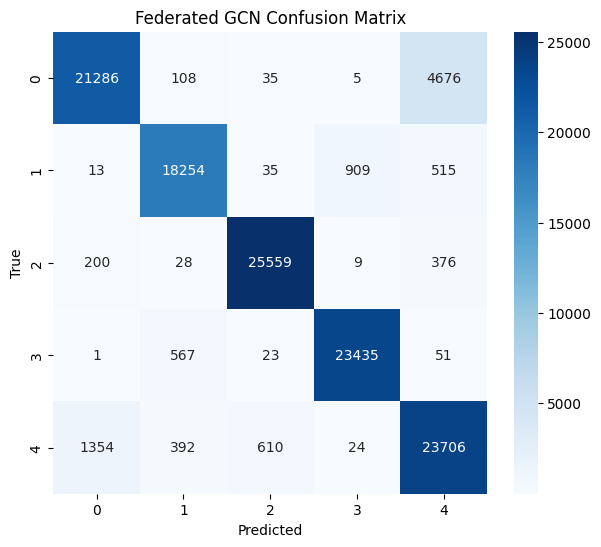

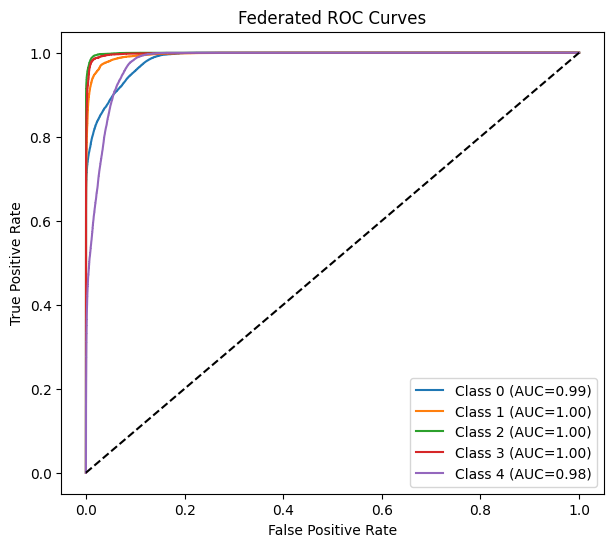

✅ All results saved as BOTH .png and .mat in:
/kaggle/working/federated_results


In [3]:
# ============================================================
# RESULTS EXPORT CELL (PNG + MAT)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ---------------------------
# 1. CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(all_true, all_preds)

# Save .mat
savemat(
    f"{OUTPUT_DIR}/confusion_matrix.mat",
    {
        "confusion_matrix": cm,
        "class_labels": np.arange(NUM_CLASSES)
    }
)

# Save .png
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Federated GCN Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# 2. ROC CURVES (PER CLASS)
# ---------------------------
y_bin = label_binarize(all_true, classes=np.arange(NUM_CLASSES))

roc_data = {}

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)

    roc_data[f"class_{i}"] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc
    }

    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Federated ROC Curves")
plt.legend()
plt.savefig(f"{OUTPUT_DIR}/roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

# Save ROC to .mat
savemat(
    f"{OUTPUT_DIR}/roc_curves.mat",
    roc_data
)

# ---------------------------
# 3. PER-CLIENT PER-ATTACK METRICS
# ---------------------------
# Assumes client CSVs already created earlier
# Convert them to .mat for MATLAB use

import glob
import pandas as pd

client_metric_files = glob.glob(f"{OUTPUT_DIR}/client_*_per_attack_metrics.csv")

client_metrics_mat = {}

for file in client_metric_files:
    client_id = os.path.basename(file).replace("_per_attack_metrics.csv","")
    df = pd.read_csv(file)
    client_metrics_mat[client_id] = df.values

savemat(
    f"{OUTPUT_DIR}/client_per_attack_metrics.mat",
    client_metrics_mat
)

# ---------------------------
# 4. GLOBAL SUMMARY METRICS
# ---------------------------
overall_accuracy = np.mean(np.array(all_true) == np.array(all_preds))

savemat(
    f"{OUTPUT_DIR}/global_summary.mat",
    {
        "overall_accuracy": overall_accuracy,
        "num_classes": NUM_CLASSES,
        "num_samples": len(all_true)
    }
)

print("✅ All results saved as BOTH .png and .mat in:")
print(OUTPUT_DIR)


**NON IID**

In [4]:
# ============================================================
# Federated GCN with NON-IID Clients (SAFE SPLIT, ONE CELL)
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc
)
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset
from scipy.io import savemat

# ---------------------------
# CONFIG
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/federated_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 10
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
K = 5
HIDDEN_DIM = 64
ALPHA = 0.3  # non-IID strength

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)
label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])

num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

# ---------------------------
# GRAPH
# ---------------------------
adj = kneighbors_graph(X_np, K, mode="connectivity", include_self=True)
adj = sp.coo_matrix(adj)

edge_pairs = np.vstack([adj.row, adj.col])
edge_labels = y_np[edge_pairs[0]]

indices = torch.tensor(edge_pairs, dtype=torch.long)
values = torch.tensor(adj.data, dtype=torch.float32)
A_sparse = torch.sparse_coo_tensor(indices, values, adj.shape).to(DEVICE)

# ---------------------------
# GLOBAL EDGE SPLIT
# ---------------------------
all_edges = np.arange(edge_pairs.shape[1])
train_edges, global_test_edges = train_test_split(
    all_edges, test_size=0.2, stratify=edge_labels, random_state=42
)

# ---------------------------
# NON-IID CLIENT SPLIT
# ---------------------------
def non_iid_edge_split(edges, labels, num_clients, alpha=0.3, seed=42):
    np.random.seed(seed)
    client_edges = [[] for _ in range(num_clients)]
    classes = np.unique(labels)

    for c in classes:
        cls_edges = edges[labels[edges] == c]
        np.random.shuffle(cls_edges)

        proportions = np.random.dirichlet(alpha * np.ones(num_clients))
        proportions = (np.cumsum(proportions) * len(cls_edges)).astype(int)[:-1]
        splits = np.split(cls_edges, proportions)

        for i in range(num_clients):
            client_edges[i].extend(splits[i])

    return [np.array(c) for c in client_edges]

client_edges = non_iid_edge_split(train_edges, edge_labels, NUM_CLIENTS, ALPHA)

# ---------------------------
# SAFE CLIENT TRAIN / TEST SPLIT
# ---------------------------
def safe_train_test_split(edges, labels, test_ratio=0.2):
    y = labels[edges]
    _, counts = np.unique(y, return_counts=True)

    if np.any(counts < 2):
        return train_test_split(edges, test_size=test_ratio, random_state=42)
    else:
        return train_test_split(
            edges,
            test_size=test_ratio,
            stratify=y,
            random_state=42
        )

client_train, client_test = [], []

for edges in client_edges:
    if len(edges) < 5:
        client_train.append(edges)
        client_test.append(edges)
    else:
        tr, te = safe_train_test_split(edges, edge_labels)
        client_train.append(tr)
        client_test.append(te)

# ---------------------------
# DATALOADER
# ---------------------------
def edge_loader(edge_idx, shuffle=True):
    src = torch.tensor(edge_pairs[0, edge_idx])
    dst = torch.tensor(edge_pairs[1, edge_idx])
    lbl = torch.tensor(edge_labels[edge_idx])
    return DataLoader(
        TensorDataset(src, dst, lbl),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# MODEL
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A):
        return torch.sparse.mm(A, X) @ self.W

class FederatedGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden)
        self.gcn2 = GCNLayer(hidden, hidden)
        self.fc1 = nn.Linear(hidden * 2, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward_edges(self, X, A, src, dst):
        h = F.relu(self.gcn1(X, A))
        h = F.relu(self.gcn2(h, A))
        e = torch.cat([h[src], h[dst]], dim=1)
        return self.fc2(F.relu(self.fc1(e)))

# ---------------------------
# TRAINING
# ---------------------------
def local_train(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(LOCAL_EPOCHS):
        for src, dst, lbl in loader:
            src, dst, lbl = src.to(DEVICE), dst.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()
            loss = loss_fn(model.forward_edges(X, A_sparse, src, dst), lbl)
            loss.backward()
            opt.step()

    return model.state_dict()

def fed_avg(states):
    return {k: torch.mean(torch.stack([s[k] for s in states]), dim=0) for k in states[0]}

# ---------------------------
# FEDERATED LEARNING
# ---------------------------
global_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

for r in range(1, ROUNDS + 1):
    print(f"Federated Round {r}")
    local_states = []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        loader = edge_loader(client_train[cid])
        local_states.append(local_train(local_model, loader))

    global_model.load_state_dict(fed_avg(local_states))

# ---------------------------
# PER-CLIENT METRICS
# ---------------------------
global_model.eval()
client_metrics = {}

with torch.no_grad():
    for cid in range(NUM_CLIENTS):
        edges = client_test[cid]
        src = torch.tensor(edge_pairs[0, edges]).to(DEVICE)
        dst = torch.tensor(edge_pairs[1, edges]).to(DEVICE)

        out = global_model.forward_edges(X, A_sparse, src, dst)
        preds = out.argmax(1).cpu().numpy()
        true = edge_labels[edges]

        p, r, f, _ = precision_recall_fscore_support(
            true, preds, average=None, zero_division=0
        )

        client_metrics[f"Client_{cid+1}"] = np.vstack([p, r, f]).T

savemat(f"{OUTPUT_DIR}/client_per_attack_metrics.mat", client_metrics)

print("✅ Training complete with SAFE non-IID clients")
print("📁 Results saved to:", OUTPUT_DIR)


Federated Round 1
Federated Round 2
Federated Round 3
Federated Round 4
Federated Round 5
Federated Round 6
Federated Round 7
Federated Round 8
Federated Round 9
Federated Round 10
✅ Training complete with SAFE non-IID clients
📁 Results saved to: /kaggle/working/federated_results
